In [1]:
import os
import gc
import glob
import torch
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

from torchvision import transforms
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from models import CRNN
from my_transforms import Resize
from utils_func import (
    four_point_transform,
    order_points,
    simplify_contour,
    decode,
    pred_to_string,
    load_json,
)

%load_ext autoreload
%autoreload 2

In [2]:
# Визуализируем детекцию (4 точки, bounding box и приближенный по маске контур)
def visualize_prediction_plate(file, model, device='cuda', verbose=True, thresh=0.0, 
                               n_colors=None, id_to_name=None):
    img = Image.open(file)
    img_tensor = my_detect_transforms(img) # ToDo: used before defined. bad practice
    print(img_tensor.shape)
    model.to(device)
    model.eval()
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]
    
    if n_colors is None:
        n_colors = model.roi_heads.box_predictor.cls_score.out_features
    
    palette = sns.color_palette(None, n_colors)
    
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    image = img
    
    blackImg = np.zeros(image.shape, image.dtype)
    blackImg[:,:] = (0, 0, 0)
    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()
        name = id_to_name[label]
        color = palette[label]
        
        if verbose:
            if score > thresh:
                print ('Class: {}, Confidence: {}'.format(name, score))
        if score > thresh:            
            crop_img = image[y_min:y_max, x_min:x_max]
            print('Bounding box:')
            show_image(crop_img, figsize=(10, 2))
            
            # В разных версиях opencv этот метод возвращает разное число параметров
            # contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
            _,contours,_ = cv2.findContours((mask > 0.05).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
#                 points = [[x_min, y_min], [x_min, y_max], [x_max, y_min],[x_max, y_max]]
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]
            
            
            points = np.array(points)
            crop_mask_img = four_point_transform(img, points)
            print('Rotated img:')
            crop_mask_img = cv2.resize(crop_mask_img, (320, 64), interpolation=cv2.INTER_AREA)
            show_image(crop_mask_img, figsize=(10, 2))
            if approx is not None:
                cv2.drawContours(image, [approx], 0, (255,0,255), 3)
            image = cv2.circle(image, (x0, y0), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x1, y1), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x2, y2), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x3, y3), radius=5, color=(0, 0, 255), thickness=-1)
            
            image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), np.array(color) * 255, 2)
            
    show_image(image)
    return prediction

# Просто показать картинку. С семинара
def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()

def get_detector_model():
    
    model = models.detection.maskrcnn_resnet50_fpn(
        pretrained=True, 
        pretrained_backbone=True,
        progress=True, 
        num_classes=91, 
    )

    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.box_predictor = box_predictor
    
    mask_predictor = MaskRCNNPredictor(256, 256, num_classes)
    model.roi_heads.mask_predictor = mask_predictor

    # Заморозим все слои кроме последних
    
    for param in model.parameters():
        param.requires_grad = False
        
    for param in model.backbone.fpn.parameters():
        param.requires_grad = True

    for param in model.rpn.parameters():
        param.requires_grad = True

    for param in model.roi_heads.parameters():
        param.requires_grad = True
    
    return model

In [3]:

my_detect_transforms = transforms.Compose([
    transforms.ToTensor()
])    

my_ocr_transforms = transforms.Compose([
    Resize(size=(320, 64)),
    transforms.ToTensor()
])



In [4]:
DATA_PATH = './data'
ALPHABET_PATH = 'models/17_06/alphabet.txt'
OCR_MODEL_PATH = 'models/17_06/new_ocr2.pt'
DETECTOR_MODEL_PATH = 'models/16_06/detector_061.pt'

test_images = glob.glob(os.path.join(DATA_PATH, 'test/*'))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

with open(ALPHABET_PATH, 'r') as f:
    alphabet = f.readline()
alphabet

'УYс8ЕА6EtехуТCСhмp0роХОOeа7MкxBР5A1в4Н9HK2тPcaВМoКmXT3k'

In [5]:
torch.cuda.empty_cache()

# load detector
mask_rcnn = get_detector_model()
mask_rcnn.load_state_dict(torch.load(DETECTOR_MODEL_PATH))
mask_rcnn.to(device)

# load rcnn
crnn = CRNN(alphabet)
crnn.load_state_dict(torch.load(OCR_MODEL_PATH))
crnn.to(device)

gc.collect()
print('ok')

ok


In [6]:
test_marks = load_json(os.path.join(DATA_PATH, 'test.json'))
resizer = Resize()
crnn.eval()

def pred_image(num, crnn):
    item = test_marks[num]
    img_path = item["file"]
    img = cv2.imread(img_path)

    results_to_sort = []
    for box in item['nums']:
        x_min, y_min, x_max, y_max = box['bbox']
        img_bbox = resizer(img[y_min:y_max, x_min:x_max])
        img_bbox = my_detect_transforms(img_bbox)
        img_bbox = img_bbox.unsqueeze(0)


        points = np.clip(np.array(box['box']), 0, None)
        img_polygon = resizer(four_point_transform(img, points))
        img_polygon = my_detect_transforms(img_polygon)
        img_polygon = img_polygon.unsqueeze(0)

        preds_bbox = crnn(img_bbox.to(device)).cpu().detach()
        preds_poly = crnn(img_polygon.to(device)).cpu().detach()

        preds = preds_poly + preds_bbox
        num_text = decode(preds, alphabet)[0]

        results_to_sort.append((x_min, num_text))

    results = sorted(results_to_sort, key=lambda x: x[0])
    num_list = [x[1] for x in results]

    plates_string = ' '.join(num_list)
    file_name = img_path[img_path.find('test/'):]
    return plates_string, file_name

In [7]:
num = 795
print(test_images[num])
test_marks[num]['file']

./data/test/831.webp


'./data/test/831.webp'

('Y173PX54', 'test/198.jpg')
./data/test/198.jpg
torch.Size([3, 505, 689])
Class: plate, Confidence: 0.9997096657752991
Bounding box:


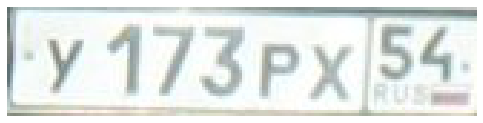

Rotated img:


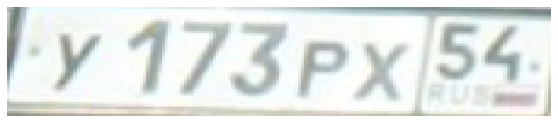

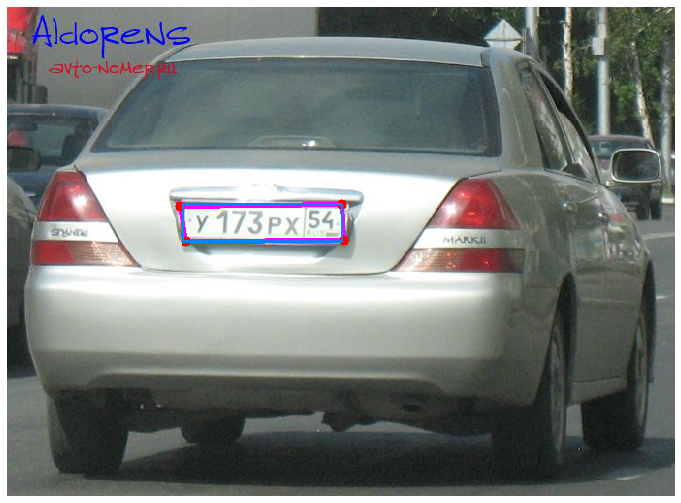

('B358HB150', 'test/199.jpg')
./data/test/199.jpg
torch.Size([3, 1040, 1268])
Class: plate, Confidence: 0.99858558177948
Bounding box:


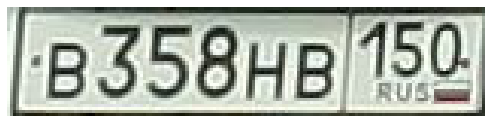

Rotated img:


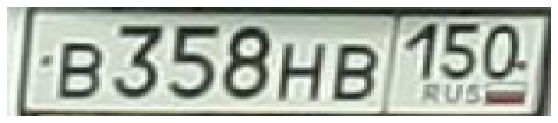

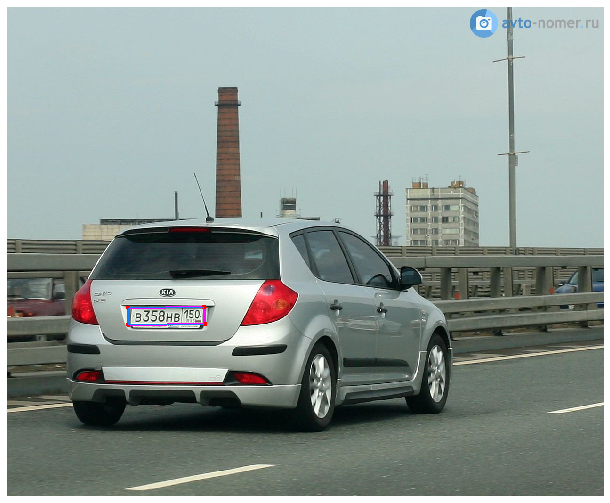

In [12]:
for name in range(198,200):
    for ind, el in enumerate(test_images):
        if el.startswith(f'./data/test/{name}.'):
            number = ind
            break
    # number = 383

    res = pred_image(number, crnn)
    print(res)
    img_name = test_images[number]
    print(img_name)
    _ = visualize_prediction_plate(img_name, mask_rcnn, id_to_name={1: 'plate'}, thresh=0.95)

In [15]:
0.5/(200/3188*100)

0.0797